In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn import svm
%matplotlib inline

Для начала загрузим данные из датасета winequality-white

In [2]:
white_wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
X = white_wine_data.drop('quality', axis = 1)
y = white_wine_data.quality

In [3]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


Посмотрим на распределение классов у исследуемого датасета.

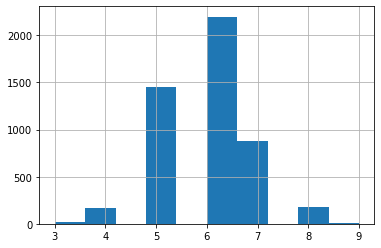

In [4]:
y.hist()

Объекты различных классов распределены неравномерно. Без предварительной подготовки данных классификаторы не будут показывать высокое качество. Чтобы это исправить мы используем алгоритм SMOTE для несбалансированных данных. Он создаст искусственные экземпляры малонаселённых классов и сократит количество экземпляров классов 6 и 7. Для корректной работы реализации SMOTETomek необходимо чётное количество классов. Объеденим 8 и 9 классы из-за малонаселённости 9.

In [5]:
new_classes = {3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8}
white_wine_data['quality'] = white_wine_data['quality'].map(new_classes)
white_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Для начала отмасштабируем значения фич.

In [6]:
Xs = pd.DataFrame(scale(X))
Xs = Xs.rename(columns = {0: 'fixed acidity',
                          1: 'volatile acidity',
                          2: 'citric acid',
                          3: 'residual sugar',
                          4: 'chlorides',
                          5: 'free sulfur dioxide',
                          6: 'total sulfur dioxide',
                          7: 'density',
                          8: 'pH',
                          9: 'sulphates',
                          10: 'alcohol'
                         })
Xs.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203


Далее разделим данные на тренировочную и тестовую выборку и применим балансный вариант алгоритма SMOTE

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.33, random_state = 0)

In [8]:
sm = SMOTETomek(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

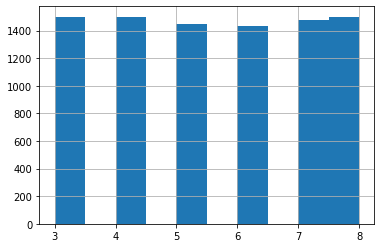

In [9]:
y_train_res = pd.Series(y_train_res)
y_train_res.hist()

In [10]:
X_train_res = pd.DataFrame(X_train_res)
X_train_res = X_train_res.rename(columns = 
                         {
                          0: 'fixed acidity',
                          1: 'volatile acidity',
                          2: 'citric acid',
                          3: 'residual sugar',
                          4: 'chlorides',
                          5: 'free sulfur dioxide',
                          6: 'total sulfur dioxide',
                          7: 'density',
                          8: 'pH',
                          9: 'sulphates',
                          10: 'alcohol'
                         })
X_train_res.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-1.250071,-0.577879,-0.365197,-1.082790,-0.538886,-0.076922,-1.161599,-1.560681,-0.319678,-1.137868,0.476014
1,1.831293,0.712005,1.866071,1.460816,0.101972,1.157980,1.215223,1.763065,-0.783300,0.790026,-0.905544
2,-1.013043,1.406558,0.626478,1.184765,-0.630437,0.863956,0.956361,0.733171,-0.319678,0.965289,-0.661739
3,0.053583,1.208114,-0.282557,0.829844,-0.584661,-0.664970,-1.208664,-0.460568,-0.253446,-0.349184,1.857572
4,-2.316697,1.902667,-1.356871,-0.885612,-0.493110,1.452004,0.226842,-1.467055,0.541334,-1.225500,0.801087


Теперь наши тренировочные данные сбалансированы. Самое время воспользоваться несколькими классификаторами и сравнить их эффективность. Важно отметить, что мы сначала разделили данные на тренировочные и тестовые и только потом применили алгоритм SMOTE только к тренировочным. В качестве метрики будем использовать меры precision, recall, accuracy и матрицу ошибок.

Для начала воспользуемся алгоритмом К-близжайших соседей или KNN. Найдём оптимальный набор параметров через сетку GridSearchCV.

In [11]:
grid_params = {
    'n_neighbors': range(3, 13, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
gs = GridSearchCV(
     KNeighborsClassifier(),
     grid_params,
     verbose = 1,
     cv = 5,
     n_jobs  = -1)

In [12]:
gs_result = gs.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.6s finished


In [13]:
gs_result.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [14]:
be = gs_result.best_estimator_

In [15]:
y_pred = be.predict(X_test)
y_pred = pd.Series(y_pred)

In [16]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           3       0.05      0.22      0.09         9
           4       0.27      0.41      0.32        66
           5       0.65      0.65      0.65       496
           6       0.67      0.52      0.59       698
           7       0.54      0.60      0.57       294
           8       0.22      0.48      0.30        54

    accuracy                           0.57      1617
   macro avg       0.40      0.48      0.42      1617
weighted avg       0.61      0.57      0.58      1617



array([[  2,   2,   2,   2,   0,   1],
       [  5,  27,  22,   8,   3,   1],
       [ 13,  33, 321, 103,  14,  12],
       [ 13,  36, 129, 366, 114,  40],
       [  5,   2,  16,  59, 175,  37],
       [  0,   1,   2,   6,  19,  26]], dtype=int64)

Далее попробуем алгоритм адаптивного бустинга

In [17]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [18]:
y_pred = pd.Series(abc.predict(X_test))

In [19]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           3       0.01      0.11      0.02         9
           4       0.13      0.50      0.21        66
           5       0.50      0.34      0.40       496
           6       0.53      0.22      0.31       698
           7       0.26      0.29      0.27       294
           8       0.06      0.35      0.10        54

    accuracy                           0.28      1617
   macro avg       0.25      0.30      0.22      1617
weighted avg       0.44      0.28      0.32      1617



array([[  1,   2,   2,   3,   0,   1],
       [  3,  33,  21,   2,   5,   2],
       [ 51, 102, 169,  73,  48,  53],
       [ 27,  88, 129, 152, 165, 137],
       [ 12,  25,  16,  46,  84, 111],
       [  0,   1,   2,   9,  23,  19]], dtype=int64)

Для небинарной классификации AdaBoosting абсолютно не подходит.

Далее воспользуемся алгоритмом случайного леса.

In [20]:
rfc = RandomForestClassifier(random_state=0)
parametrs = {'n_estimators': range(40, 51, 10),
             'max_depth': range(1, 12, 2),
             'min_samples_leaf': range(1, 10),
             'min_samples_split': range(2, 10, 2)
            }

In [21]:
grid_search_cv_clf = GridSearchCV(rfc, parametrs, cv=3, n_jobs=-1)

In [22]:
grid_search_cv_clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [23]:
grid_search_cv_clf.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [24]:
best_est = grid_search_cv_clf.best_estimator_

In [25]:
y_pred = pd.Series(best_est.predict(X_test))

In [26]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           3       0.05      0.11      0.06         9
           4       0.27      0.39      0.32        66
           5       0.65      0.63      0.64       496
           6       0.65      0.55      0.59       698
           7       0.55      0.58      0.56       294
           8       0.26      0.52      0.35        54

    accuracy                           0.57      1617
   macro avg       0.40      0.46      0.42      1617
weighted avg       0.60      0.57      0.58      1617



array([[  1,   3,   2,   3,   0,   0],
       [  3,  26,  26,   8,   3,   0],
       [  9,  32, 314, 125,  12,   4],
       [  9,  29, 126, 383, 113,  38],
       [  0,   6,  18,  62, 170,  38],
       [  0,   1,   0,  12,  13,  28]], dtype=int64)

На данный момент алгоритм случайного леса дал наилучший результат по всем метрикам. Посмотрим на важность фич в данном случае.

In [27]:
pd.DataFrame(best_est.feature_importances_).rename(
                        index=
                        {
                         0: 'fixed acidity',
                         1: 'volatile acidity',
                         2: 'citric acid',
                         3: 'residual sugar',
                         4: 'chlorides',
                         5: 'free sulfur dioxide',
                         6: 'total sulfur dioxide',
                         7: 'density',
                         8: 'pH',
                         9: 'sulphates',
                         10: 'alcohol'
                         },
                        columns = {0: 'importance'})

,importance
fixed acidity,0.081380
volatile acidity,0.098286
citric acid,0.083780
residual sugar,0.075278
chlorides,0.070353
free sulfur dioxide,0.134393
total sulfur dioxide,0.092434
density,0.081762
pH,0.077217
sulphates,0.072320


Рассмотрим метод опорных векторов

In [28]:
svc = svm.SVC()
svc.fit(X_train_res, y_train_res)

C:\Users\AlexandeR\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [29]:
y_pred = pd.Series(svc.predict(X_test))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.20      0.41      0.27        66
           5       0.60      0.60      0.60       496
           6       0.60      0.35      0.44       698
           7       0.35      0.45      0.40       294
           8       0.15      0.48      0.23        54

    accuracy                           0.45      1617
   macro avg       0.32      0.38      0.32      1617
weighted avg       0.52      0.45      0.47      1617



array([[  0,   2,   4,   2,   1,   0],
       [  5,  27,  25,   4,   3,   2],
       [ 21,  52, 296,  92,  29,   6],
       [ 11,  44, 150, 245, 189,  59],
       [  4,  10,  16,  54, 132,  78],
       [  0,   2,   0,   8,  18,  26]], dtype=int64)

Из всего этого напрашивается вывод, что даже при использовании ресемплинга данных, классификаторы показывают низкое качество на первоначально малочисленных классах. При этом мы не можем воспользоваться алгоритмами бинарной классификации. Попробуем другой подход - перейдём к 2-м классам. Классы 3, 4, 5 будут нулевым классом, в то время как 6, 7, 8, 9 - первым. Будем работать без оверсемплинга, чтобы не искажать данные.

In [30]:
new_classes = {3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}
white_wine_data['quality_new'] = white_wine_data['quality'].map(new_classes)
white_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_new
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


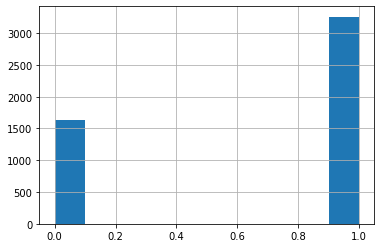

In [31]:
X = white_wine_data.drop(columns = ['quality', 'quality_new'])
y = white_wine_data.quality_new
y.hist()

Теперь наши классы сбалансированы относительно. Посмотрим как изменятся метрики наших классификаторов.

In [32]:
Xs = pd.DataFrame(scale(X))
Xs = Xs.rename(columns = {0: 'fixed acidity',
                          1: 'volatile acidity',
                          2: 'citric acid',
                          3: 'residual sugar',
                          4: 'chlorides',
                          5: 'free sulfur dioxide',
                          6: 'total sulfur dioxide',
                          7: 'density',
                          8: 'pH',
                          9: 'sulphates',
                          10: 'alcohol'
                         })
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.33, random_state = 0)

KNN:

In [33]:
grid_params = {
    'n_neighbors': range(3, 70, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
gs = GridSearchCV(
     KNeighborsClassifier(),
     grid_params,
     verbose = 1,
     cv = 5,
     n_jobs  = -1)

In [34]:
gs_result = gs.fit(X_train, y_train)
be = gs_result.best_estimator_

Fitting 5 folds for each of 204 candidates, totalling 1020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1020 out of 1020 | elapsed:   18.2s finished


In [35]:
gs_result.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

In [36]:
y_pred = be.predict(X_test)
y_pred = pd.Series(y_pred)

In [37]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.64      0.71       571
           1       0.82      0.92      0.87      1046

    accuracy                           0.82      1617
   macro avg       0.81      0.78      0.79      1617
weighted avg       0.82      0.82      0.81      1617



array([[364, 207],
       [ 88, 958]], dtype=int64)

В KNN значение accuracy поднялось с 0.57 до 0.82

AdaBoost:

In [38]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train, y_train)
y_pred = pd.Series(abc.predict(X_test))

In [39]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       571
           1       0.78      0.86      0.82      1046

    accuracy                           0.76      1617
   macro avg       0.73      0.71      0.72      1617
weighted avg       0.75      0.76      0.75      1617



array([[325, 246],
       [150, 896]], dtype=int64)

Адаптивный бустинг на бинарной классификации дал результат accuracy = 0.79 против 0.28.

RandomForest:

In [40]:
rfc = RandomForestClassifier(random_state=0)
parametrs = {'n_estimators': range(10, 51, 10),
             'max_depth': range(1, 12, 2),
             'min_samples_leaf': range(1, 10),
             'min_samples_split': range(2, 10, 2)
            }
grid_search_cv_clf = GridSearchCV(rfc, parametrs, cv=3, n_jobs=-1)

In [41]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [42]:
grid_search_cv_clf.best_params_

{'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 40}

In [43]:
best_est = grid_search_cv_clf.best_estimator_
y_pred = pd.Series(best_est.predict(X_test))

In [44]:
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.77      0.57      0.65       571
           1       0.79      0.91      0.85      1046

    accuracy                           0.79      1617
   macro avg       0.78      0.74      0.75      1617
weighted avg       0.78      0.79      0.78      1617



array([[323, 248],
       [ 98, 948]], dtype=int64)

RandomForest показал рост accuracy с 0.57 до 0.79. Посмотрим на важность фич.

In [45]:
pd.DataFrame(best_est.feature_importances_).rename(
                        index=
                        {
                         0: 'fixed acidity',
                         1: 'volatile acidity',
                         2: 'citric acid',
                         3: 'residual sugar',
                         4: 'chlorides',
                         5: 'free sulfur dioxide',
                         6: 'total sulfur dioxide',
                         7: 'density',
                         8: 'pH',
                         9: 'sulphates',
                         10: 'alcohol'
                         },
                        columns = {0: 'importance'})

,importance
fixed acidity,0.054035
volatile acidity,0.134208
citric acid,0.077760
residual sugar,0.075363
chlorides,0.070072
free sulfur dioxide,0.104626
total sulfur dioxide,0.079580
density,0.109907
pH,0.052716
sulphates,0.060181


Из этого можно сделать вывод, что при разбиении белого вина на 2 класса, больше всего влияет уровень алкоголя и летучей кислоты.

C:\Users\AlexandeR\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1, "volatile acidity percent in each level of red wine's quality")

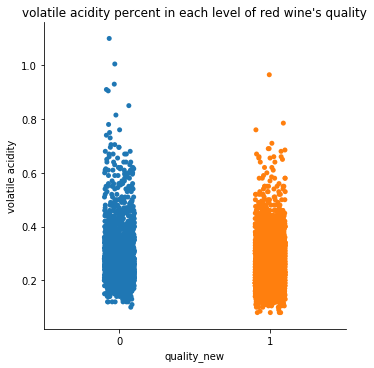

In [46]:
sb.factorplot(x="quality_new", y="volatile acidity", data=white_wine_data, kind="strip")
plt.title("volatile acidity percent in each level of red wine's quality")

Text(0.5, 1, "Alcohol percent in each level of red wine's quality")

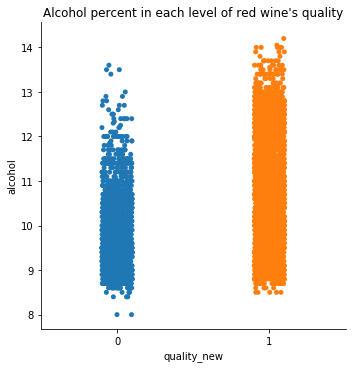

In [47]:
sb.factorplot(x="quality_new", y="alcohol", data=white_wine_data, kind="strip")
plt.title("Alcohol percent in each level of red wine's quality")

SVM:

In [48]:
svc = svm.SVC()
svc.fit(X_train, y_train)

C:\Users\AlexandeR\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [49]:
y_pred = pd.Series(svc.predict(X_test))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.73      0.55      0.63       571
           1       0.78      0.89      0.83      1046

    accuracy                           0.77      1617
   macro avg       0.76      0.72      0.73      1617
weighted avg       0.77      0.77      0.76      1617



array([[315, 256],
       [115, 931]], dtype=int64)

SVC дал рост accuracy с 0.45 до 0.76

Сравним метрику Accuracy:
Алгоритм       Небинарная классификация    Бинарная классификация
KNN            0.57                        0.82
AdaBoost       0.28                        0.76
Random Forest  0.57                        0.79
SVC            0.45                        0.76

На основании проведённых эсперементов можно сделать заключение о том, что в условиях данной задачи при наличии 6-7 классов и дисбаланса данных, наилучшее качество классификации дают алгоритмы К-близжайших соседей KNN и случайного леса RandomForest. Он же является наиболее ресурсоёмким алгоритмом из всех испробованных. При бинарной классификации на данных по белому вину лидирует KNN. Отметим, что несмотря на ресемплинг, ни один алгоритм не дал нам хоть какой-то значимой оценки данных малонаселённых классов. Рекомендуем переходить к двум классам. Это даст более высокое качество классификации в смысле точности и выскоих показателей F1-меры. С прикладной точки зрения мы получаем предсказание качества вина в терминах 'ниже среднего' и 'выше среднего', что может являться полезной рекомендацией в вопросах выбора.